In [35]:
import numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt
import keras

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

REMOVE_DUPLICATE_EEG_IDS = True # if True, each row in training corresponds to a unique eeg_id
AVERAGE_TARGETS_OVER_EEG = True
MAX_ROWS = None # use only MAX_ROWS rows of train.csv, set to None to use all rows
USE_CACHE = True # stores all accessed eeg and spectrogram files in memory

DATA_DIR = 'data' # /kaggle/input/hms-harmful-brain-activity-classification/
READ_SPG_FILES = False
READ_EEG_SPG_FILES = False

N_EPOCHS = 4

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [36]:
train_csv = pd.read_csv(f'{DATA_DIR}/train.csv', dtype={'eeg_label_offset_seconds': 'int', 'spectrogram_label_offset_seconds': 'int'})
TARGETS = train_csv.columns[-6:]

def actual_median(s):
    return s.iloc[(s - s.median()).abs().argsort().iloc[0]]

if REMOVE_DUPLICATE_EEG_IDS:
    df_unique_eeg = train_csv.groupby('eeg_id')[['eeg_label_offset_seconds']].agg(actual_median)
    train_df = pd.merge(df_unique_eeg, train_csv, on=['eeg_id', 'eeg_label_offset_seconds'], how='left')
    
    if AVERAGE_TARGETS_OVER_EEG:
        y = train_csv.groupby('eeg_id')[TARGETS].agg('sum')
        y = y.div(y.sum(axis=1), axis=0)
        train_df[TARGETS] = y[TARGETS].values
else:
    train_df = train_csv


train_df = train_df[:MAX_ROWS]

train_df

,eeg_id,eeg_label_offset_seconds,eeg_sub_id,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,6,1,789577333,1,6,3640441665,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,18,5,1552638400,5,18,1179854295,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,0,0,14960202,12,1008,3254468733,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,0,0,618728447,4,908,2898467035,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,0,0,52296320,0,0,3255875127,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,0,0,1188113564,0,0,447244163,16610,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,0,0,1549502620,0,0,1618953053,15065,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,0,0,2105480289,0,0,469526364,56,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,6,2,657299228,2,6,3251917981,4312,Other,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [37]:
from functools import cache

def read_parquet(path):
    @cache
    def f(id_):
        return pd.read_parquet(f'{path}{id_}.parquet')
    return f

read_eeg_train = read_parquet(path=f'{DATA_DIR}/train_eegs/')
read_eeg_test = read_parquet(path=f'{DATA_DIR}/test_eegs/')
read_spg_train = read_parquet(path=f'{DATA_DIR}/train_spectrograms/')
read_spg_test = read_parquet(path=f'{DATA_DIR}/test_spectrograms/')

In [38]:
if READ_SPG_FILES:
    spgs = {}
    for i, spg_id in enumerate(train_df['spectrogram_id'].unique()):
        spgs[spg_id] = read_spg_train(spg_id).iloc[:, 1:].values
        if i % 1000 == 0:
            print(i, end=',')
else:
    spgs = np.load(f'{DATA_DIR}/specs.npy', allow_pickle=True).item()

eeg_spgs = np.load(f'{DATA_DIR}/eeg_specs.npy', allow_pickle=True).item()

In [44]:
import albumentations as albu

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, test_mode=False, spgs=None, eeg_spgs=None, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.test_mode = test_mode
        self.spgs = spgs
        self.eeg_spgs = eeg_spgs
        self.indices = np.arange(len(self.data))
        if test_mode:
            self.read_spg = read_spg_test
            self.read_eeg = read_eeg_test
        else:
            self.read_spg = read_spg_test
            self.read_eeg = read_eeg_test
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Denotes the number of batches per epoch"""
        n, r = divmod(len(self.data), self.batch_size)
        return n + (1 if r > 0 else 0)

    def __getitem__(self, i):
        """Generate one batch of data"""
        indices = self.indices[(i * self.batch_size):((i + 1) * self.batch_size)]
        X, y = self.__data_generation(indices)
        if self.augment:
            X = self.__augment_batch(X) 
        return X, y
    
    def __data_generation(self, indices):
        X = np.zeros((len(indices), 128, 256, 8), dtype='float32')
        y = np.zeros((len(indices), 6), dtype='float32')
        # img = np.ones((128, 256), dtype='float32')

        for i_batch, i_row in enumerate(indices):
            row = self.data.iloc[i_row]
            
            if self.spgs:
                spg = self.spgs[row['spectrogram_id']]
            else:
                spg = self.read_spg(row['spectrogram_id']).iloc[:, 1:].values
            
            if self.test_mode:
                spg_offset = 0
            else:
                spg_offset = row['spectrogram_label_offset_seconds'] // 2
            
            for j in range(4):
                img = spg[spg_offset:(spg_offset + 300), (j * 100):((j + 1) * 100)].T

                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                img = img - img.mean()
                img = img / (img.std() + 1e-6)
                img = np.nan_to_num(img, nan=0.0)

                X[i_batch, :, :, j] = tf.image.resize(img[:, :, np.newaxis], (128, 256))[:, :, 0]  # EXPERIMENT: try resize_with_pad
                # X[i_batch, :, :, j] = tf.image.resize_with_pad(img[:, :, np.newaxis], 128, 256)[:, :, 0]  # EXPERIMENT: try resize
                # X[i_batch, :, :, j] = tf.image.resize_with_crop_or_pad(img[:, :, np.newaxis], 128, 256)[:, :, 0]

            
            if self.eeg_spgs:
                img = self.eeg_spgs[row['eeg_id']]
            else:
                img = np.zeros((128, 256, 4), dtype='float32') # TODO: implement
            
            img = (img - img.mean(axis=(0, 1))) / (img.std(axis=(0, 1)) + 1e-6)
            img = np.nan_to_num(img, nan=0.0)
            X[i_batch, :, :, 4:] = img

            if not self.test_mode:
                y[i_batch, :] = row[TARGETS]
        return X, y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            #albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch


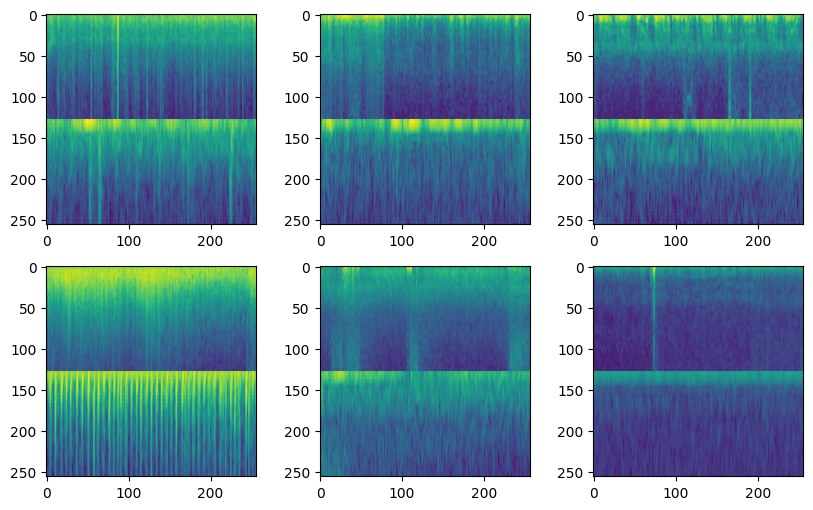

In [45]:
gen = DataGenerator(train_df, spgs=spgs, eeg_spgs=eeg_spgs, shuffle=False)

ROWS = 2
COLS = 3
BATCHES = 1

for i, (X, y) in enumerate(gen):
    plt.figure(figsize=(10, 6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j * COLS + k + 1)
            t = y[j * COLS + k]
            img = np.concatenate([X[j * COLS + k, :, :, a] for a in [0, 4]], axis=0)
            plt.imshow(img)
    plt.show()
    if i == BATCHES - 1:
        break

In [46]:
def build_model():
    base_model = keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=None)

    inputs = keras.Input(shape=(128,256,8))

    x1 = keras.layers.Concatenate(axis=1)([inputs[:, :, :, i:(i + 1)] for i in range(0, 4)])
    x2 = keras.layers.Concatenate(axis=1)([inputs[:, :, :, i:(i + 1)] for i in range(4, 8)])
    x = keras.layers.Concatenate(axis=2)([x1, x2])
    x = keras.layers.Concatenate(axis=3)([x, x, x])

    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(loss=keras.losses.KLDivergence(), optimizer=keras.optimizers.Adam(learning_rate=1e-3))

    return model

In [47]:
from sklearn.model_selection import GroupKFold

out_of_folds_predicts = []
out_of_folds_labels = []

group_k_fold = GroupKFold(n_splits=5)
for i, (train_indices, valid_indices) in enumerate(group_k_fold.split(train_df, groups=train_df.patient_id)):
    print(f'{"_" * 30} Fold {i} {"_" * 30}')

    train_data_gen = DataGenerator(train_df.iloc[train_indices], shuffle=True, spgs=spgs, eeg_spgs=eeg_spgs)
    valid_data_gen = DataGenerator(train_df.iloc[valid_indices], shuffle=False, spgs=spgs, eeg_spgs=eeg_spgs)

    model = build_model()
    model.fit(train_data_gen, validation_data=valid_data_gen, epochs=1, verbose=1)
    model.save_weights(f'model_en0_f{i}.weights.h5')

    out_of_folds_predicts.append(model.predict(valid_data_gen))
    out_of_folds_labels.append(train_df.iloc[valid_indices][TARGETS].values)
    
    break

out_of_folds_predicts = np.concatenate(out_of_folds_predicts)
out_of_folds_labels = np.concatenate(out_of_folds_labels)


______________________________ Fold 0 ______________________________
428/428 ━━━━━━━━━━━━━━━━━━━━ 230s 425ms/step - loss: 0.8159 - val_loss: 1.3730
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 269ms/step


In [48]:
from kaggle_kl_div import score

out_of_folds_predicts_df = pd.DataFrame(out_of_folds_predicts.copy())
out_of_folds_predicts_df['id'] = np.arange(len(out_of_folds_predicts))

out_of_folds_labels_df = pd.DataFrame(out_of_folds_labels.copy())
out_of_folds_labels_df['id'] = np.arange(len(out_of_folds_labels))

score(solution=out_of_folds_labels_df, submission=out_of_folds_predicts_df, row_id_column_name='id')


1.3730882262482298